In [1008]:
import numpy as np
import gymnasium as gym
import time

In [1009]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False,render_mode='human').unwrapped
States = env.observation_space.n
Actions = env.action_space.n

In [1010]:
list(range(Actions))

[0, 1, 2, 3]

0: Move left

1: Move down

2: Move right

3: Move up

In [1011]:
terminal = [s for s in env.P if all(all(done for _, _, _, done in env.P[s][a]) for a in env.P[s])]

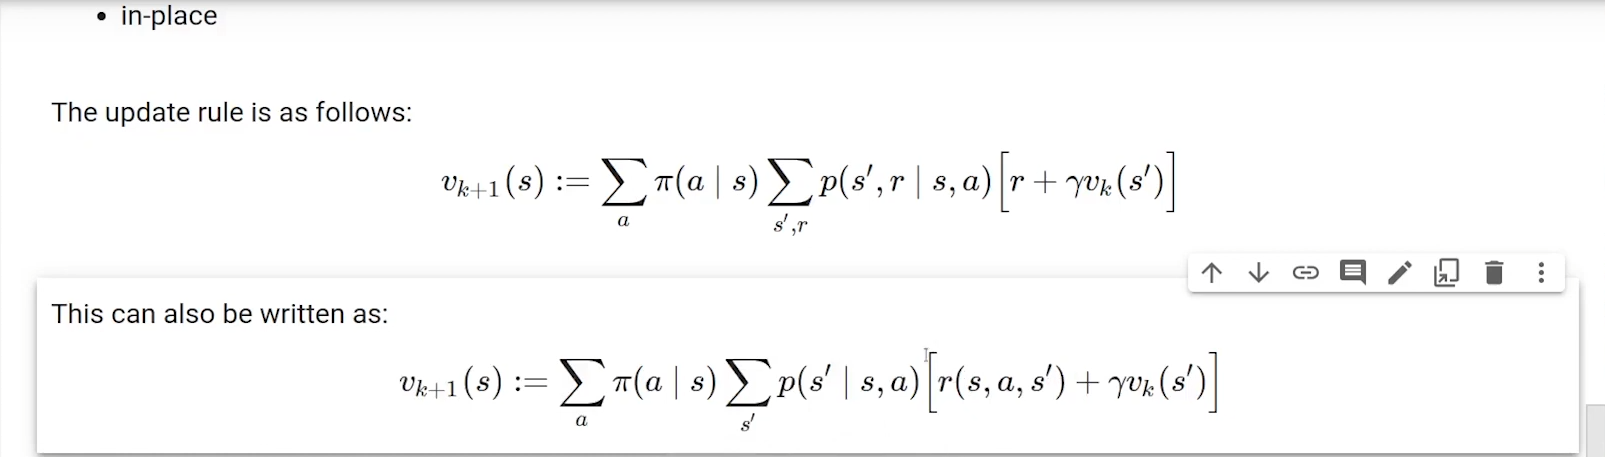

In [1012]:
env.P[10]

{0: [(1.0, 9, 0.0, False)],
 1: [(1.0, 14, 0.0, False)],
 2: [(1.0, 11, 0.0, True)],
 3: [(1.0, 6, 0.0, False)]}

In [1013]:
def run_policy(policy, episodes=10, render=True):
    """
    Runs a given policy in an OpenAI Gym environment.

    Parameters:
    - env: OpenAI Gym environment.
    - policy: Dictionary mapping states to actions {state: action}.
    - episodes: Number of episodes to run.
    - render: Whether to render the environment.

    Returns:
    - rewards: List of total rewards per episode.
    """
    rewards = []

    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):  # If env returns (obs, info) in new gym versions
            state = state[0]

        total_reward = 0
        done = False

        while not done:
            if render:
                env.render()
                time.sleep(1)


            action = np.random.choice(np.arange(Actions),p=policy[state]) # Choose action according to policy
            next_state, reward, done, _, _ = env.step(action)  # Support for Gym v26+

            total_reward += -1
            state = next_state

        rewards.append(total_reward)
    return rewards

In [1014]:
[s for s in range(States)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [1015]:
def policy_eval_synch(pi,theta=1e-3,gamma=1):
  delta = theta + 1
  v = np.zeros(States)
  iter = 0
  while(delta>=theta):
    iter+=1
    v_next = np.zeros(States)
    delta = 0
    for s in range(States):
      if s in terminal:
        # v_next[s] = -10 if s!=15 else 10
        continue
      for a in range(Actions):
        temp =0
        for prob,s_next,reward,_ in env.P[s][a]:
          if s != s_next:
            reward = +1
          temp +=prob*(reward + gamma*v[s_next])
        v_next[s] += pi[s][a]*temp
      delta = max(delta , abs(v[s]-v_next[s]))
    v = v_next.copy()
  v = np.round(v,3)
  return iter,v

In [1016]:
def policy_eval_asynch(pi,theta,gamma=1):
  delta = theta + 1
  v = np.zeros(States)
  iter = 0
  while(delta>=theta):
    iter+=1
    delta = 0
    for s in range(States):
      vs = 0
      if s in terminal:  #as gamma is 1
        # v[s] = -10 if s!=15 else 10
        continue
      for a in range(Actions):        
        temp = 0
        for prob,s_next,reward,_ in env.P[s][a]:
          if s != s_next:
            reward = +1
          temp += prob*(reward + gamma*v[s_next])
        vs += pi[s][a]*temp
      delta = max(delta , abs(v[s]- vs))
      v[s] = vs
  v = np.round(v,3)
  return iter,v

In [1017]:
def policy_imp(v,gamma=1):
  #new policy
  pi_next = np.array([np.zeros(Actions) for _ in range(States)])
  #new action-policy
  q = np.array([np.zeros(Actions) for _ in range(States)])
  for s in range(States):
    if s in terminal:  #as gamma is 1
      # v[s] += -10 if s!=15 else 10
      continue
    for a in range(Actions):
      for prob,s_next,reward,_ in env.P[s][a]:
        q[s][a] += prob*(reward + gamma*v[s_next])
    amax = np.argmax(q[s])
    pi_next[s][amax] = 1.0
  return pi_next

In [1018]:
# pi = np.array([np.ones(Actions)/Actions for _ in range(States)])
pi = np.array([np.array([0,0,1,0]) for _ in range(States)])
iter,v = policy_eval_synch(pi,1e-4)
iter1,v1 = policy_eval_asynch(pi,1e-4)

print(iter)
print(v.reshape(4,4))

4
[[3. 2. 1. 0.]
 [1. 0. 1. 0.]
 [3. 2. 1. 0.]
 [0. 2. 1. 0.]]


In [1019]:
# [[0.009 0.008 0.017 0.008]
#  [0.013 0.    0.039 0.   ]
#  [0.032 0.086 0.14  0.   ]
#  [0.    0.173 0.437 0.   ]]

In [1020]:
print(iter1)
print(v1.reshape(4,4))

4
[[3. 2. 1. 0.]
 [1. 0. 1. 0.]
 [3. 2. 1. 0.]
 [0. 2. 1. 0.]]


In [1021]:
# [[0.011 0.01  0.019 0.009]
#  [0.015 0.    0.04  0.   ]
#  [0.034 0.088 0.142 0.   ]
#  [0.    0.175 0.439 0.   ]]

##Policy Iterations

In [1022]:
def policy_iter():
  pi_next = np.array([np.ones(Actions)/Actions for _ in range(States)])
  pi = np.zeros((States,Actions))
  v = np.zeros(States)
  iter =0
  while not np.array_equal(pi,pi_next):
    pi = pi_next.copy()
    # print("\npi: ",pi)
    _,v = policy_eval_synch(pi,1e-7)
    # print("\nV",v)
    pi_next = policy_imp(v)
    iter+=1
    if iter==100000:
      break
  return iter,pi_next,v

In [1023]:

iter2,pi2,v2 = policy_iter()
print(iter2)
print(np.round(v2,3).reshape(4,-1))
print(np.argmax(np.round(pi2,3),axis=1).reshape(4,-1))
# run_policy(pi2)

100000
[[0. 1. 2. 3.]
 [1. 0. 3. 0.]
 [2. 3. 4. 0.]
 [0. 4. 5. 0.]]
[[1 2 1 2]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 1 0]]


Value Iterations

In [1024]:
def value_iter(theta,gamma=1):
  delta = theta + 1
  v = np.zeros(States)
  iter = 0
  while(delta>=theta):
    iter+=1
    delta = 0
    #new policy
    pi_val_iter = np.array([np.ones(Actions)/Actions for _ in range(States)])
    #new action-policy
    q = np.array([np.zeros(Actions) for _ in range(States)])
    for s in range(States):
      vs = 0
      if s in terminal:  #as gamma is 1
        # v[s] = -10 if s!=15 else 0
        continue
      for a in range(Actions):
          # reward = -10 if s in terminal else -1  
        for prob,s_next,reward,_ in env.P[s][a]:
          q[s][a] += prob*(reward + gamma*v[s_next])
      vs = np.max([q[s][a] for a in range(Actions)])
      amax = np.argmax([q[s][a] for a in range(Actions)])
      pi_val_iter[s][amax] = 1
      delta = max(delta , abs(v[s]- vs))
      v[s] = vs
  return (v,pi_val_iter,delta,iter)

In [ ]:
v3,pi3,delta,iter3 = value_iter(1e-7)
print(iter3)
print(delta)
print(np.round(v3,3).reshape(4,-1))
# print(np.round(pi3,3))
print(np.argmax(np.round(pi3,3),axis=1).reshape(4,-1))
# run_policy(pi3)

7
0
[[1. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 1. 0.]
 [0. 1. 1. 0.]]
[[0 0 0 0]
 [0 0 1 0]
 [0 0 0 0]
 [0 1 0 0]]


: 

0: Move left

1: Move down

2: Move right

3: Move up